In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

### Load data

In [2]:
# data set of images of dogs and cats
X = loadmat("data/datamatrix.mat")['Y']
n,m = X.shape

In [3]:
# images are 64 x 64 = 4096 dimensional, where X_ij \in {0, 1, ..., 255}
X.shape

(4096, 198)

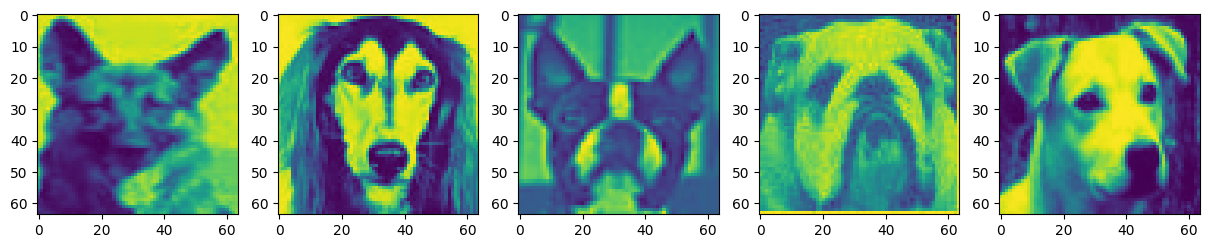

In [4]:
plt.figure(figsize=(3*5, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.reshape(X[:, -(i+1)], [64, 64]).T)
plt.show()

### Forward encoder

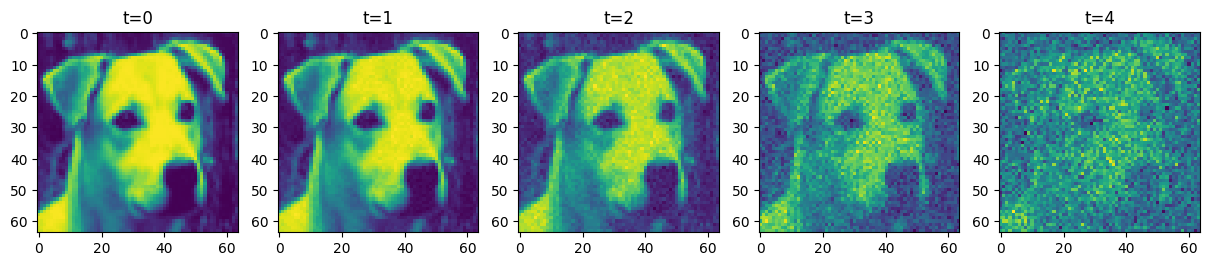

In [5]:
# starting with original image, corrupt with Gaussian noise
# z_t = sqrt(1 - B1) * z_{t-1} + sqrt(B1) e_t, e_t ~ N(0, 1)
# q(z_t | z_{t-1}) = N(z_t | sqrt(1 - B1) * z_{t-1}, B1) 

# number of steps
T = 5

# noise at each step
beta_t = .9 * np.ones(T)

# initial point
z_t = X[:, -5]

plt.figure(figsize=(3*T, 3))
for i in range(T):
    plt.subplot(1, T, i+1)
    plt.imshow(np.reshape(z_t, [64, 64]).T)
    plt.title(f"t={i}")
    
    # sample noise
    e_t = np.sqrt(beta_t[i]) * np.random.randn(*z_t.shape)

    # update 
    z_t = np.sqrt(1 - beta_t[i]) * z_t + e_t
    
plt.show()
    

### Diffusion kernel

What is the conditional distribution of z_t given x? 

$$ q(z_t, ..., z_1 | x) = q(z_t | z_{t-1}) \cdot ... \cdot q(z_1 | x) $$ 

$$ q(z_t | x) = \int_{z_1} ... \int_{z_{t-1}}  q(z_t | z_{t-1}) \; \cdot \; \ldots \; \cdot q(z_1 | x) \; d z_{t-1} \; \cdot \ldots \cdot d z_1 $$ 

$$ q(z_t | x) = \mathcal{N}(z_t | \sqrt{\alpha_t} x, (1 - \alpha_t) \mathbf{I}), \quad \alpha_t = \prod_{\tau=1}^t (1 - \beta_{\tau}) $$ 

This distribution is called the 'diffusion kernel', which allows for sampling from any point without having to compute the entire chain! 

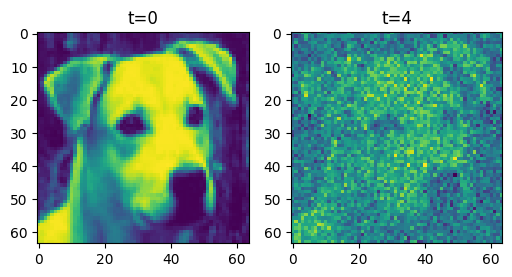

In [6]:
# define number of steps
T = 4

# function to compute alpha_t
alpha_t = lambda t: jnp.prod(1. - beta_t[jnp.arange(t)])
A = alpha_t(T)

# initial point
x = X[:, -5]

# sample noise
e_t = np.sqrt(1 - A) * np.random.randn(*x.shape)

# sample from diffusion kernel 
z_t = np.sqrt(A) * x + e_t

plt.figure(figsize=(3*2, 3))
plt.subplot(1, 2, 1)
plt.imshow(np.reshape(x, [64, 64]).T)
plt.title("t=0")

plt.subplot(1, 2, 2)
plt.imshow(np.reshape(z_t, [64, 64]).T)
plt.title(f"t={T}")

plt.show()

### Conditional distribution

If we can sample from the distribution $q(z_{t-1} | z_t)$, we can sample noise and compute the chain to generate a sample from $q(x)$.

While it's not tractable to compute $q(z_{t-1} | z_t)$ exactly, the distribution conditioned on the original image $q(z_{t-1} | z_t, x)$ has an analytical solution, 

$$ q(z_{t-1} | z_t, x) = \frac{q(z_t | z_{t-1}, x) q(z_{t-1} | x) }{ q(z_t | x) } $$ 

$$ q(z_{t-1} | z_t, x) = \mathcal{N}(z_{t-1} | m_t (x, z_t), \sigma_t^2 \mathbf{I}) $$ 

where
$$ m_t(x, z_t) = \frac{(1 - \alpha_{t-1}) \sqrt{1 - \beta_t} z_t + \sqrt{\alpha_{t-1}} \beta_t x} {1 - \alpha_t} $$

$$ \sigma_t = \frac{\beta_t (1 - \alpha_{t-1})}{1 - \alpha_t} $$ 

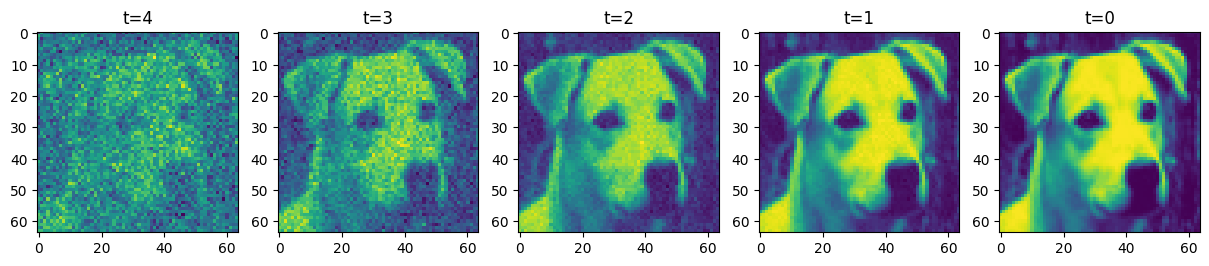

In [7]:
# define number of steps
T = 5

# function to compute alpha_t
alpha_t = lambda t: jnp.prod(1. - beta_t[jnp.arange(t)])
A = alpha_t(T-1)

# initial point
x = X[:, -5]

# sample noise
e_t = np.sqrt(1 - A) * np.random.randn(*x.shape)

# sample from diffusion kernel 
z_t = np.sqrt(A) * x + e_t

plt.figure(figsize=(3*5, 3))
plt.subplot(1, 5, 1)
plt.imshow(np.reshape(z_t, [64, 64]).T)
plt.title(f"t={T-1}")

for i, t in enumerate(np.arange(1, T)[::-1]):

    # alpha(t-1=a)
    A_a = alpha_t(t-1)
    
    # alpha(t=b)
    A_b = alpha_t(t) 

    # mean of conditional
    m_b = ((1 - A_a) * np.sqrt(1 - beta_t[i]) * z_t + np.sqrt(A_a) * beta_t[i] * x) / (1 - A_b)
    
    # variance of conditional 
    v_b = beta_t[i] * (1 - A_a) / (1 - A_b)  
    
    # sample from conditional (think of this as z_a, update t <- t-1) 
    z_t  = m_b + np.sqrt(v_b) * np.random.randn(*x.shape)

    plt.subplot(1, 5, i+2)
    plt.imshow(np.reshape(z_t, [64, 64]).T)
    plt.title(f"t={t-1}")

plt.show()

### Reverse decoder

To sample from $q(x)$, we want to learn how to sample from the distribution $q(z_{t-1} | z_t)$. The reverse decoder approximates this distribution and is denoted as $p(z_{t-1} | z_t, w)$, where $w$ are learnable parameters of the distribution. 

$$ q(z_{t-1} | z_t) \approx p(z_{t-1} | z_t, w) = \mathcal{N}(\mu(z_t, w), \beta_t) $$ 
where $\mu(z_t, w)$ is a function of $z_t$ with parameters $w$. Because the input and output of $\mu(z_t, w)$ are the same dimension, a U-net convolutional neural network architecture is typically used. 

### Learning the reverse decoder

Let $Z = \{z_1, ..., z_T\}$ be a sequence of latent variables and $q(Z)$ is the unknown true distribution over sequences of latent variables. We want to learn an approximate distribution $p(Z | w)$ where $w$ are the parameters of the approximate distribution. We can decompose the distribution as, 

$$ p(Z | w) = p(z_T) \cdot \prod_{t=1}^T p(z_{t-1} | z_{t}, w) $$

$$ p(Z | w) = p(z_T) \cdot \prod_{t=1}^T \mathcal{N}(z_{t-1} | \mu(z_t, w), \beta_t) $$

The approximate distribution can be optimized by minimizing the KL divergence between $p(Z|w)$ and $q(Z)$, 

$$ \mathcal{L}(w) = \text{KL} \left[ q(Z) || p(Z | w)  \right] $$

$$ \mathcal{L}(w) = - \int_Z q(Z) \frac{ \mathrm{ln} \; p(Z|w)}{q(Z)} \; \mathrm{d} Z $$

Keeping terms that depend on $w$, 

$$ \mathcal{L}(w) = - \int_Z q(Z) \; \mathrm{ln} \; p(Z | w) \mathrm{d} Z $$ 

We can approximate this integral using Monte Carlo samples, $Z^{\ell} \sim q(Z)$, 

$$ \mathcal{L}(w) \approx -\frac{1}{L} \sum_{\ell=1}^{L} \mathrm{ln} \; p(Z^{\ell} | w)  $$

$$ \mathcal{L}(w) = -\frac{1}{L} \sum_{\ell=1}^L \sum_{t=1}^{T} \mathrm{ln} \; \mathcal{N}(z_{t-1}^{\ell} | \mu(z_t^{\ell}, w), \beta_t) $$

$$ \mathcal{L}(w) = \frac{1}{L} \sum_{\ell=1}^L \sum_{t=1}^T \frac{1}{2 \beta_t} || z_{t-1}^{\ell} - \mu(z_t^{\ell}, w) ||^2 $$

We can think of data as a set of random, independent samples, $\mathcal{D} = \{x_1, ..., x_N\}$. Given a random sample from the data, $x^{\ell} \sim \mathcal{D}$, we can generate a sequence of latent variables, $Z^{\ell}$. Stochastic optimization of $\mathcal{L}(w)$ involves evaluating the function for each randomly sampled data point and a randomly sampled time point $t \sim \{1, ..., T\}$. 